<a href="https://colab.research.google.com/github/YS-JEOUNG/amazon-review-project/blob/main/code/artscrafts_stat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import pandas as pd
import numpy as np
import gzip
import json

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline

import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Data

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
df = getDF('/content/drive/MyDrive/Colab Notebooks/project/Arts_Crafts_and_Sewing.json.gz')

In [ ]:
metadf = getDF('/content/drive/MyDrive/Colab Notebooks/project/meta_Arts_Crafts_and_Sewing.json.gz')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875917 entries, 0 to 2875916
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   vote            object 
 2   verified        bool   
 3   reviewTime      object 
 4   reviewerID      object 
 5   asin            object 
 6   style           object 
 7   reviewerName    object 
 8   reviewText      object 
 9   summary         object 
 10  unixReviewTime  int64  
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 266.0+ MB


In [ ]:
metadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302988 entries, 0 to 302987
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      302988 non-null  object
 1   tech1         302988 non-null  object
 2   description   302988 non-null  object
 3   fit           302988 non-null  object
 4   title         302988 non-null  object
 5   also_buy      302988 non-null  object
 6   image         302988 non-null  object
 7   tech2         302988 non-null  object
 8   brand         302988 non-null  object
 9   feature       302988 non-null  object
 10  rank          302988 non-null  object
 11  also_view     302988 non-null  object
 12  details       302988 non-null  object
 13  main_cat      302988 non-null  object
 14  similar_item  302988 non-null  object
 15  date          302988 non-null  object
 16  price         302988 non-null  object
 17  asin          302988 non-null  object
dtypes: object(18)
memory usa

In [ ]:
total = pd.merge(df, metadf, how='left', on='asin')

In [ ]:
total = total.drop(['image_x', 'tech1', 'fit', 'also_buy', 'tech2', 'image_y', 'also_view', 'similar_item', 'feature', 'details'], axis=1)

In [ ]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2911389 entries, 0 to 2911388
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   vote            object 
 2   verified        bool   
 3   reviewTime      object 
 4   reviewerID      object 
 5   asin            object 
 6   style           object 
 7   reviewerName    object 
 8   reviewText      object 
 9   summary         object 
 10  unixReviewTime  int64  
 11  category        object 
 12  description     object 
 13  title           object 
 14  brand           object 
 15  rank            object 
 16  main_cat        object 
 17  date            object 
 18  price           object 
dtypes: bool(1), float64(1), int64(1), object(16)
memory usage: 424.8+ MB


In [ ]:
# check for missing values
total.isnull().sum()

overall                 0
vote              2534349
verified                0
reviewTime              0
reviewerID              0
asin                    0
style             1764066
reviewerName          201
reviewText           2544
summary               965
unixReviewTime          0
category             8668
description          8668
title                8668
brand                8668
rank                 8668
main_cat             8668
date                 8668
price                8668
dtype: int64

In [ ]:
# drop null values in product title column in pandas
total = total.dropna(subset=['title'])

In [ ]:
# check missing values
total.isnull().sum()

overall                 0
vote              2527428
verified                0
reviewTime              0
reviewerID              0
asin                    0
style             1760927
reviewerName          201
reviewText           2540
summary               963
unixReviewTime          0
category                0
description             0
title                   0
brand                   0
rank                    0
main_cat                0
date                    0
price                   0
dtype: int64

In [ ]:
# fill null values in brand name with first word from title
total.loc[total.brand.isnull(), 'brand'] = total.title.str.split().str.get(0)

In [ ]:
total = total.dropna(subset=['vote', 'style', 'reviewerName', 'reviewText', 'summary'])

In [ ]:
total.isnull().sum()

overall           0
vote              0
verified          0
reviewTime        0
reviewerID        0
asin              0
style             0
reviewerName      0
reviewText        0
summary           0
unixReviewTime    0
category          0
description       0
title             0
brand             0
rank              0
main_cat          0
date              0
price             0
dtype: int64

In [ ]:
# 'summary'와 'reviewText' 합치기
total['review_text'] = total[['summary', 'reviewText']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis=1)

In [ ]:
total = total.drop(['summary', 'reviewText'], axis=1)

In [ ]:
total['review_text'][2046]

"Solid buy, few small gripes about page layout I have to be honest - I already have quite a collection of Moleskine notebooks and love them all. However, I will say that I found this recipe journal to be the perfect companion. I consider myself a home cook with a penchant for collecting, organizing and categorizing my recipes into favorites folders within Firefox. However, it isn't always safe for my computer on the kitchen counter.\n\nThe pages in the recipe journal give you enough room to record a standard recipe if you don't mind keeping your handwriting pretty small. I had to shrink mine a bit after a few of my longer recipes had ingredients squeezed into the margins. I found the space for rating the recipes - 0 to 5 stars - a little unnecessary. If I think a recipe is worth anything BUT 5 stars, I'm not wasting any Moleskine pages on it at all.\n\nLoved the blank tabbed pages in the back and the adjoining stickers - there are LOTS to choose from - that let you create your own sect

In [ ]:
# 리뷰 추천수 vote, NaN은 0으로 변환
total['vote'] = total['vote'].fillna(0)

In [ ]:
# classify ratings as good
good_rate = len(total[total['overall'] >= 3])
bad_rate = len(total[total['overall'] < 3])

# printing rates and their total numbers
print(f'Good ratings: {good_rate} reviews')
print(f'Bad ratings: {bad_rate} reviews')

Good ratings: 112992 reviews
Bad ratings: 30239 reviews


In [ ]:
# apply the new classification to the ratings column
total['rating_class'] = total['overall'].apply(lambda x: 'bad' if x < 3 else 'good')
total.shape

(143231, 19)

In [ ]:
# checking duplicates based on 'asin', 'reviweName', and 'unixReviewTime' columns: 중복된 리뷰 확인
total[total.duplicated(['reviewerName', 'unixReviewTime', 'asin'], keep=False)]

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,unixReviewTime,category,description,title,brand,rank,main_cat,date,price,review_text,rating_class
4396,5.0,2,True,"12 26, 2012",A1HQLS79C6VCS1,B00002N6GD,{'Size Name:': ' Pack of 24'},Carmen Cordova,1356480000,"[Arts, Crafts & Sewing, Painting, Drawing & Ar...",[This item is Jen Mfg. Foam Brush Poly Foam Br...,Jen Manufacturing 8500-D 4&quot; Foam Brush w...,"Jen Mfg., Inc.","[>#111,766 in Tools & Home Improvement (See To...",Tools & Home Improvement,,$13.50,Only brush l use I love them paint put in zip...,good
4397,5.0,2,True,"12 26, 2012",A1HQLS79C6VCS1,B00002N6GD,{'Size Name:': ' Pack of 24'},Carmen Cordova,1356480000,"[Arts, Crafts & Sewing, Painting, Drawing & Ar...",[This item is Jen Mfg. Foam Brush Poly Foam Br...,Jen Manufacturing 8500-D 4&quot; Foam Brush w...,"Jen Mfg., Inc.","[>#111,766 in Tools & Home Improvement (See To...",Tools & Home Improvement,,$13.50,Only brush l use I love them paint put in zip...,good
4498,5.0,2,True,"07 25, 2014",A1CS41KME12RQ8,B00002N6GD,{'Size Name:': ' Pack of 24'},Jon Myers,1406246400,"[Arts, Crafts & Sewing, Painting, Drawing & Ar...",[This item is Jen Mfg. Foam Brush Poly Foam Br...,Jen Manufacturing 8500-D 4&quot; Foam Brush w...,"Jen Mfg., Inc.","[>#111,766 in Tools & Home Improvement (See To...",Tools & Home Improvement,,$13.50,Best Foam Brush I have ever used I have been u...,good
4499,5.0,2,True,"07 25, 2014",A1CS41KME12RQ8,B00002N6GD,{'Size Name:': ' Pack of 24'},Jon Myers,1406246400,"[Arts, Crafts & Sewing, Painting, Drawing & Ar...",[This item is Jen Mfg. Foam Brush Poly Foam Br...,Jen Manufacturing 8500-D 4&quot; Foam Brush w...,"Jen Mfg., Inc.","[>#111,766 in Tools & Home Improvement (See To...",Tools & Home Improvement,,$13.50,Best Foam Brush I have ever used I have been u...,good
4504,5.0,2,True,"05 22, 2014",A3076BNRCXCXLM,B00002N6GD,{'Size Name:': ' Pack of 24'},EvenMax,1400716800,"[Arts, Crafts & Sewing, Painting, Drawing & Ar...",[This item is Jen Mfg. Foam Brush Poly Foam Br...,Jen Manufacturing 8500-D 4&quot; Foam Brush w...,"Jen Mfg., Inc.","[>#111,766 in Tools & Home Improvement (See To...",Tools & Home Improvement,,$13.50,Best foam brushes out there Jen foam brushes a...,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432978,5.0,2,True,"12 16, 2017",A1XDBKP1IYWKYB,B0000CAPBW,{'Color:': ' pccat-18'},Dominique,1513382400,"[Arts, Crafts & Sewing, Organization, Storage ...",[Imge Series Front Load Stacking Desk TraysCon...,"Eldon(R) Image(R) Legal Tray, Clear",Eldon,"[>#727,912 in Office Products (See top 100), >...",Office Products,"April 18, 2008",,Best gift for a dog lover. This is so awesome....,good
2432979,5.0,2,True,"12 16, 2017",A1XDBKP1IYWKYB,B0000CAPBW,{'Color:': ' pccat-18'},Dominique,1513382400,"[Arts, Crafts & Sewing, Organization, Storage ...",[Imge Series Front Load Stacking Desk TraysCon...,"Eldon(R) Image(R) Legal Tray, Clear",Eldon,"[>#727,912 in Office Products (See top 100), >...",Office Products,"April 18, 2008",,Best gift for a dog lover. This is so awesome....,good
2432980,4.0,2,True,"09 28, 2017",AHSYSCPS9ASBG,B0000CAPBW,{'Color:': ' pccat-20'},Amazon Customer,1506556800,"[Arts, Crafts & Sewing, Organization, Storage ...",[Imge Series Front Load Stacking Desk TraysCon...,"Eldon(R) Image(R) Legal Tray, Clear",Eldon,"[>#727,912 in Office Products (See top 100), >...",Office Products,"April 18, 2008",,Four Stars Worked as it should.,good
2432981,4.0,2,True,"09 28, 2017",AHSYSCPS9ASBG,B0000CAPBW,{'Color:': ' pccat-20'},Amazon Customer,1506556800,"[Arts, Crafts & Sewing, Organization, Storage ...",[Imge Series Front Load Stacking Desk TraysCon...,"Eldon(R) Image(R) Legal Tray, Clear",Eldon,"[>#727,912 in Office Products (See top 100), >...",Office Products,"April 18, 2008",,Four Stars Worked as it should.,good


In [ ]:
# 중복되는 리뷰들은 그 중 첫 번째것만 남기기
total = total.drop_duplicates(['asin', 'reviewerName', 'unixReviewTime'], keep='first')

In [ ]:
total.shape

(130133, 19)

In [ ]:
# convert time object to datetime and create a new column named 'time'
total['time'] = total.reviewTime.str.replace(',', "")
total['time'] = pd.to_datetime(total['time'], format = '%m %d %Y')
total = total.drop('reviewTime', axis=1)
total.head()

,overall,vote,verified,reviewerID,asin,style,reviewerName,unixReviewTime,category,description,title,brand,rank,main_cat,date,price,review_text,rating_class,time
2045,5.0,9,True,APVFJYDRTYNK5,886293162X,{'Format:': ' Paperback'},Mrs. Sally L. C. Marsh,1290816000,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[The new Volant Address Book has ruled pages w...,"Moleskine Volant Address Book, Large, Magenta,...",Moleskine,"[>#514,989 in Office Products (See top 100), >...",Office Products,"January 10, 2009",,"Nice and perfect for an address book Thin, you...",good,2010-11-27
2046,4.0,69,True,A3BQSWC3801JNI,8862933177,{'Format:': ' Hardcover'},Stacy A. Jones,1267660800,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,"Solid buy, few small gripes about page layout ...",good,2010-03-04
2047,5.0,5,True,A1RY2FJR0TVP85,8862933177,{'Format:': ' Hardcover'},N. M. Patterson,1267056000,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,Cool place to Catalog Your Recipes I purchased...,good,2010-02-25
2055,2.0,2,True,A12GULZW3W4W3P,8862933177,{'Format:': ' Hardcover'},Jazz,1499299200,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,Its ok read for specifications I did not like ...,bad,2017-07-06
2056,5.0,2,True,A2G1BD6F2WR4YW,8862933177,{'Format:': ' Hardcover'},rrobey619,1498003200,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,Great for Chefs. I'm a chef and I was looking ...,good,2017-06-21


In [ ]:
# rename the columns
total.columns = ['overall', 'vote', 'verified', 'reviewer_id', 'asin', 'style', 'reviewer_name', 'unix_review_time', 'category', 'description', 'title', 'brand', 'rank', 'main_cat', 'date', 'price', 'review_text', 'rating_class', 'time']
total.head()

,overall,vote,verified,reviewer_id,asin,style,reviewer_name,unix_review_time,category,description,title,brand,rank,main_cat,date,price,review_text,rating_class,time
2045,5.0,9,True,APVFJYDRTYNK5,886293162X,{'Format:': ' Paperback'},Mrs. Sally L. C. Marsh,1290816000,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[The new Volant Address Book has ruled pages w...,"Moleskine Volant Address Book, Large, Magenta,...",Moleskine,"[>#514,989 in Office Products (See top 100), >...",Office Products,"January 10, 2009",,"Nice and perfect for an address book Thin, you...",good,2010-11-27
2046,4.0,69,True,A3BQSWC3801JNI,8862933177,{'Format:': ' Hardcover'},Stacy A. Jones,1267660800,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,"Solid buy, few small gripes about page layout ...",good,2010-03-04
2047,5.0,5,True,A1RY2FJR0TVP85,8862933177,{'Format:': ' Hardcover'},N. M. Patterson,1267056000,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,Cool place to Catalog Your Recipes I purchased...,good,2010-02-25
2055,2.0,2,True,A12GULZW3W4W3P,8862933177,{'Format:': ' Hardcover'},Jazz,1499299200,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,Its ok read for specifications I did not like ...,bad,2017-07-06
2056,5.0,2,True,A2G1BD6F2WR4YW,8862933177,{'Format:': ' Hardcover'},rrobey619,1498003200,"[Arts, Crafts & Sewing, Crafting, Paper & Pape...",[Build your very own film archive. Fully embos...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"[>#229,441 in Office Products (See top 100), >...",Office Products,"November 3, 2009",$137.58,Great for Chefs. I'm a chef and I was looking ...,good,2017-06-21


In [ ]:
total['vote'] = total['vote'].str.replace(',', '').astype(int)

# Descriptive statistics

In [ ]:
# descriptive statistics

print('=====================')

# total reviews
print('number of reviews:', len(total))
print()

# How many unique reviewers?
print('number of reviewers:', len(total.reviewer_id.unique()))
reviewer_prop = float(len(total.reviewer_id.unique())/len(total))
print('prop of unique reviewers:', round(reviewer_prop, 3))
print()

# How many unique products?
print('number of unique products:', len(total.asin.unique()))
product_prop = float(len(total.asin.unique())/len(total))
print('prop of unique products:', round(product_prop, 3))
print()

# average star score
print('average rating score:', round(total.overall.mean(), 3))

# average helpful ratio
print('average helpful ratio score:', round(total.vote.mean(), 3))

number of reviews: 130133

number of reviewers: 111107
prop of unique reviewers: 0.854

number of unique products: 14060
prop of unique products: 0.108

average rating score: 3.907
average helpful ratio score: 8.02


In [ ]:
# read statistics of numeric variables
total[['overall', 'vote']].describe()

,overall,vote
count,130133.000000,130133.000000
mean,3.907034,8.020164
std,1.490606,32.370262
min,1.000000,2.000000
25%,3.000000,2.000000
50%,5.000000,3.000000
75%,5.000000,6.000000
max,5.000000,3783.000000


Text(0, 0.5, 'number of reviews')

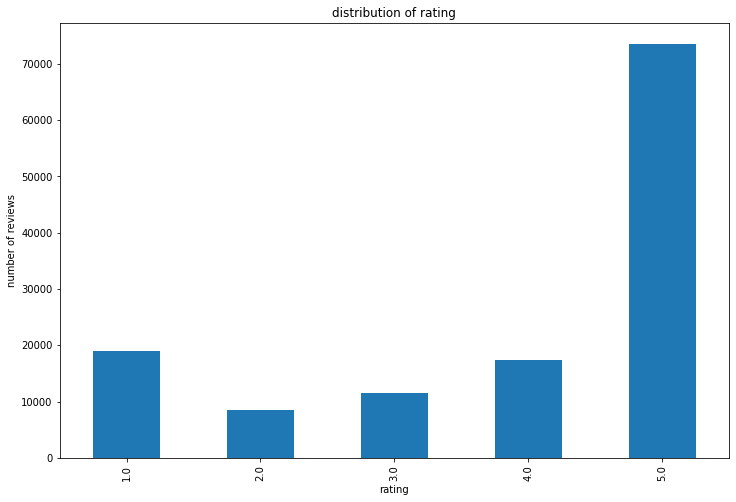

In [ ]:
# plot distribution of rating

plt.figure(figsize=(12, 8))
total['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('distribution of rating')
plt.xlabel('rating')
plt.ylabel('number of reviews')

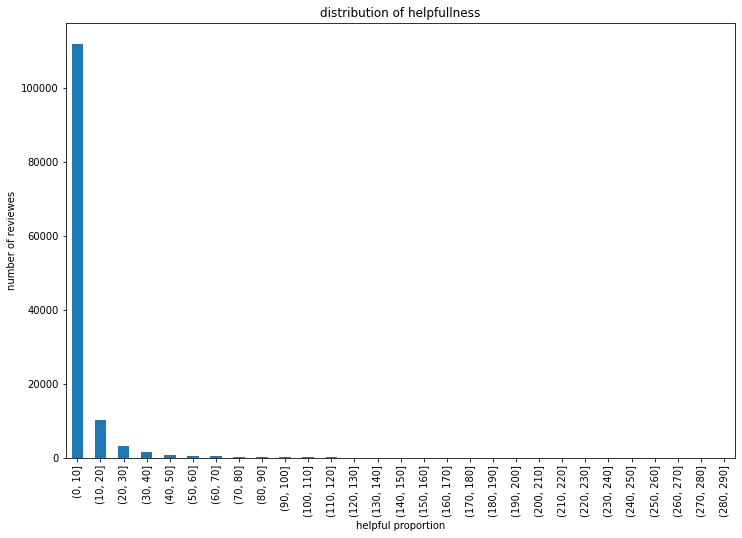

In [ ]:
# distribution of helpfullness

plt.figure(figsize=(12, 8))
cutoff = np.arange(0, 300, 10)

dist_help = total.groupby([pd.cut(total['vote'], bins=cutoff)]).size()
dist_help.plot(kind='bar')

plt.title('distribution of helpfullness')
plt.xlabel('helpful proportion')
plt.ylabel('number of reviewes')
plt.show()

In [ ]:
# distribution of rating score

class_counts = total.groupby('overall').size()
class_counts

overall
1.0    18995
2.0     8538
3.0    11598
4.0    17441
5.0    73561
dtype: int64

In [ ]:
# customer totals for each rating class
total['rating_class'].value_counts()

good    102600
bad      27533
Name: rating_class, dtype: int64

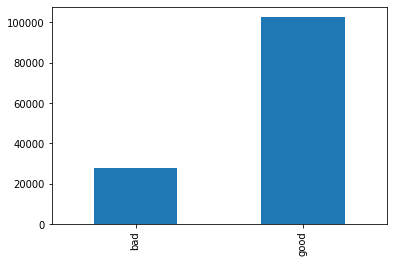

In [ ]:
total['rating_class'].value_counts().sort_index().plot(kind='bar')

In [ ]:
# statistics of non-numeric variables

# number of unique customers
print(f'number of unique customers: {len(total.reviewer_id.unique())}')

# number of unique products
print(f'number of unique products: {len(total.asin.unique())}')

# review number per unique customer
print(f'review per customer: {len(total)/len(total.reviewer_id.unique())}')

# review number per unique product
print(f'review per product: {len(total)/len(total.asin.unique())}')

number of unique customers: 111107
number of unique products: 14060
review per customer: 1.171240335892428
review per product: 9.255547652916073


# 파일 저장

In [ ]:
total.to_csv('/content/drive/MyDrive/Colab Notebooks/project/arts_total.csv', sep=',', encoding='utf-8', index=False)